In [1]:
import pandas as pd
from src.data import DataLoader
from src.preprocessing import PreProcessClass
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%reload_ext autoreload
%autoreload 2

loader = DataLoader("datasets2025")
consumer_it, temp_it, pred_it = loader.load_data(country="IT")
consumer_es, temp_es, pred_it = loader.load_data(country="ES")

In [2]:
loader_it = PreProcessClass(consumer_it, temp_it)
consumers_it_df = []
for cust in consumer_it.columns:
    tmp_df = loader_it.preprocess_nonan(cust)
    tmp_df["id"] = cust
    consumers_it_df.append(tmp_df)

print(len(consumers_it_df))
consumers_it_df = pd.concat(consumers_it_df)

1696


In [3]:
consumers_it_df = consumers_it_df[["Consumption", "id"]]
agg_funcs = {
    "Consumption": ["mean", "std", "max", "min", "median", "skew"],
}

grouped = consumers_it_df.groupby("id").agg(agg_funcs)
grouped.columns = ["_".join(col) for col in grouped.columns]
grouped.reset_index(inplace=True)

In [4]:
grouped.describe()

,Consumption_mean,Consumption_std,Consumption_max,Consumption_min,Consumption_median,Consumption_skew
count,1696.000000,1696.000000,1696.000000,1696.000000,1696.000000,1696.000000
mean,0.125682,0.073395,0.294748,0.024893,0.117148,1.033631
std,0.317948,0.175840,0.700145,0.077660,0.341733,1.308489
min,0.000000,0.000000,0.000000,0.000000,0.000000,-2.365844
25%,0.002070,0.001490,0.007000,0.000008,0.001039,0.195585
50%,0.016505,0.013694,0.054957,0.000896,0.009763,0.806652
75%,0.112661,0.073534,0.308650,0.007125,0.080400,1.495776
max,4.864967,2.188290,11.687808,1.249320,5.206250,9.426794


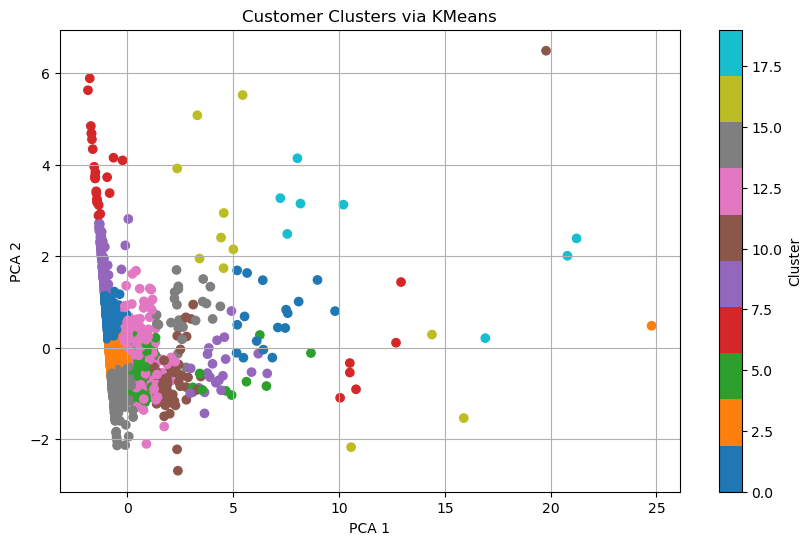

         Consumption_mean  Consumption_std  Consumption_max  Consumption_min  \
Cluster                                                                        
0                0.009759         0.010319         0.047058         0.001618   
1                1.217052         0.762327         2.491977         0.044130   
2                0.019186         0.015288         0.059327         0.003071   
3                4.864967         1.364318         6.804500         0.657000   
4                0.835178         0.220441         1.396187         0.457641   
5                0.216981         0.083044         0.406472         0.088575   
6                0.007137         0.015190         0.113296         0.002469   
7                2.061426         0.715691         3.334039         0.361907   
8                0.821178         0.386881         1.451552         0.122689   
9                0.004270         0.006287         0.040166         0.000736   
10               2.354792         2.1882

In [5]:
# -------------------------------
# 3. Normalize the feature space
# -------------------------------
features = grouped.drop(columns=["id"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# -------------------
# 4. Apply KMeans
# -------------------
k = 20  # You can adjust this
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
grouped["Cluster"] = kmeans.fit_predict(X_scaled)

# ---------------------------
# 5. Visualize the clusters
# ---------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=grouped["Cluster"], cmap="tab10")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Clusters via KMeans")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

print(grouped.groupby("Cluster")[features.columns].mean())

In [6]:
cluster_dict = grouped[["id", "Cluster"]].set_index("id").to_dict()["Cluster"]

In [7]:
consumers_it_df["cluster"] = consumers_it_df["id"].map(cluster_dict)
consumers_it_df["color"] = consumers_it_df["Consumption"].apply(
    lambda x: "r" if pd.isna(x) else "b"
)
df = consumers_it_df.copy()

In [8]:
import pandas as pd

# Ensure the index is datetime
df.index = pd.to_datetime(df.index)

df["date"] = df.index

# Compute the mean Consumption per (cluster, date)
cluster_date_means = (
    df.groupby(["cluster", "date"])["Consumption"]
    .mean()
    .reset_index()
    .rename(columns={"Consumption": "mean_consumption"})
)

# Merge the means back to the original DataFrame
df = df.reset_index()  # Temporarily make the datetime a column for merge
df = df.merge(cluster_date_means, how="left", on=["cluster", "date"])

# Fill NaNs in 'Consumption' with the mean
df["Consumption"] = df["Consumption"].fillna(df["mean_consumption"])

# Clean up
df = df.drop(columns=["mean_consumption", "date"])
df = df.set_index("index")  # Restore original datetime index

In [9]:
df[(df["id"] == "VALUEMWHMETERINGDATA_customerIT_545")]

,Consumption,id,cluster,color
index,,,,
2022-01-01 00:00:00,0.097009,VALUEMWHMETERINGDATA_customerIT_545,13,b
2022-01-01 01:00:00,0.096764,VALUEMWHMETERINGDATA_customerIT_545,13,b
2022-01-01 02:00:00,0.096453,VALUEMWHMETERINGDATA_customerIT_545,13,b
2022-01-01 03:00:00,0.097247,VALUEMWHMETERINGDATA_customerIT_545,13,b
2022-01-01 04:00:00,0.097077,VALUEMWHMETERINGDATA_customerIT_545,13,b
...,...,...,...,...
2024-07-31 19:00:00,0.503281,VALUEMWHMETERINGDATA_customerIT_545,13,b
2024-07-31 20:00:00,0.509671,VALUEMWHMETERINGDATA_customerIT_545,13,b
2024-07-31 21:00:00,0.499603,VALUEMWHMETERINGDATA_customerIT_545,13,b


<Axes: xlabel='index'>

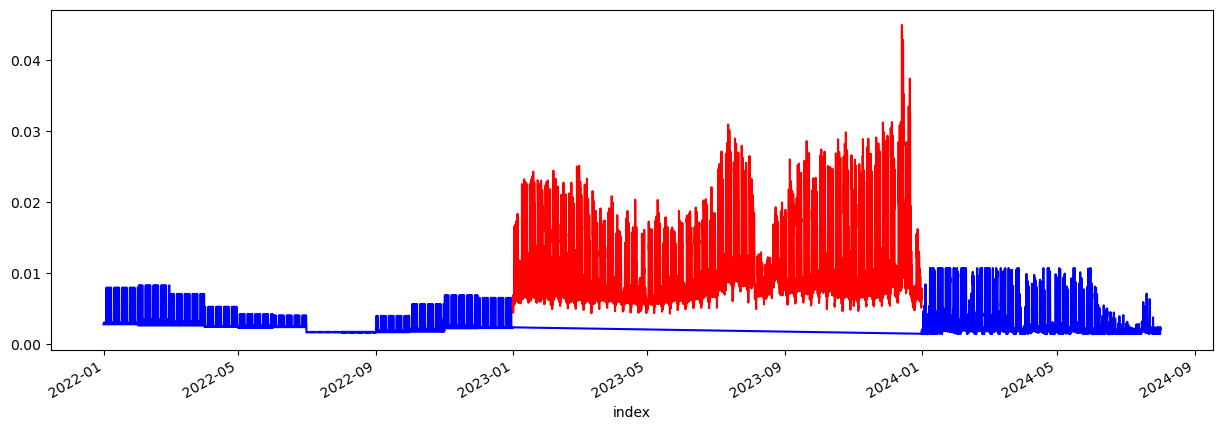

In [10]:
df[(df["id"] == "VALUEMWHMETERINGDATA_customerIT_1966") & (df["color"] == "b")][
    "Consumption"
].plot(figsize=(15, 5), color="blue")
df[(df["id"] == "VALUEMWHMETERINGDATA_customerIT_1966") & (df["color"] == "r")][
    "Consumption"
].plot(figsize=(15, 5), color="red")

In [11]:
consumers_it_df.groupby("id")["Consumption"].apply(
    lambda x: x.isna().sum()
).sort_values(ascending=False).head(10)

id
VALUEMWHMETERINGDATA_customerIT_759     13150
VALUEMWHMETERINGDATA_customerIT_2775    13150
VALUEMWHMETERINGDATA_customerIT_193      9503
VALUEMWHMETERINGDATA_customerIT_1944     9119
VALUEMWHMETERINGDATA_customerIT_1960     8759
VALUEMWHMETERINGDATA_customerIT_1952     8759
VALUEMWHMETERINGDATA_customerIT_1951     8759
VALUEMWHMETERINGDATA_customerIT_545      8759
VALUEMWHMETERINGDATA_customerIT_1966     8759
VALUEMWHMETERINGDATA_customerIT_1950     8759
Name: Consumption, dtype: int64

In [12]:
consumers_it_df[
    consumers_it_df["id"] == "VALUEMWHMETERINGDATA_customerIT_712"
].isna().sum()

Consumption    6
id             0
cluster        0
color          0
dtype: int64